# Benamou-Brenier

We illustrate in this notebook the fundamental link between static and dynamic optimal transport as highlighted by {cite}`benamou:00`. This notebook showcases some math-heavy parts of OTT-JAX and how it can be used to illustrate OT theory.


In [1]:
import functools
from typing import Callable, Optional

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython import display

from ott.geometry import costs
from ott.math import legendre
from ott.math import utils as mu

DARKMODE = True
if DARKMODE:
    plt.style.use("dark_background")

## From Brenier Potential to Benamou-Brenier Velocity Field

Our goal in this notebook will be to illustrate solutions to the {term}`Benamou-Brenier` problem. How can we recover such a solution from $\varphi$? Namely, how can we recover $v_t(x)$ for any $x$ and any $t\in[0,1]$ from $\varphi$?

We start from the fundamental relation linking the {term}`Monge map` to the optimal {term}`Benamou-Brenier` velocity field,

$$ 
v_t(x + t(\nabla\varphi(x)-x)) = \nabla\varphi(x) -x\,.
$$

Hence, writing $z:=x_t$, the first practical task is to reverse
engineer which starting point $x$ may land on $z$ on its path to $T(x)=\nabla\varphi(x)$ at time $t$. In particular note that the equation above can be written as follows:

$$
z = \nabla (\tfrac12(1-t)\|\cdot\|^2 + t\varphi)(x)\,.
$$

Since $\varphi_t : = \tfrac12(1-t)\|\cdot\|^2 + t\varphi$ is strictly convex for $t\in[0,1[$, one has therefore that the starting point whose transport segment landed at $z$ at time $t$ is therefore:

$$
x = \nabla \varphi_t^*(z),
$$

where we use the {term}`Legendre transform` of $\varphi_t$, denoted as $\varphi_t^*$. As a result, and for any $z$ and time $t\in[0,1]$, one has:

$$
v_t(z) = \nabla\varphi\circ\nabla \varphi_t^*(z) - \nabla \varphi_t^*(z)\,,
$$

which is coded in the function below.

## Define a ground truth Brenier potential

We dive into mathematics directly: By virtue of the {term}`Brenier theorem`, one can use any convex potential to define a ground truth optimal transport map, i.e. pick a convex function $\varphi$ to define a {term}`Monge map` $\nabla\varphi$ that is optimal w.r.t. the squared-Euclidean distance . Namely, picking any starting measure $\mu$, we will define $\nu:= \nabla \varphi\#\mu$ and can guarantee that $\nabla\varphi$ is the optimal map linking $\mu$ to $\nu$. 

We start by defining such a convex potential, and make some efforts to avoid using a simple quadratic potential (that would result in an affine map) to define something slightly more elaborate for illustration purposes.

In [2]:
# Define ground truth potential phi
A = jnp.array(((0.9, 0.6), (0.2, -0.5)))  # linear transform
B = jnp.array(((0.2, -0.05), (-0.05, 0.1)))  # positive definite matrix.

assert jnp.linalg.det(B) > 0.0, jnp.linalg.det(B)


def phi(x: jnp.ndarray) -> jnp.ndarray:
    """Real-valued convex potential function."""
    return (
        jnp.sum(jnp.log(1.0 + jnp.exp(B @ x)))
        + 0.5 * jnp.sum(jnp.abs(A @ x) ** 1.5)
        + 0.1 * mu.logsumexp(10 * x)
        + x[0]
    )

We can plot the contours of that potential.

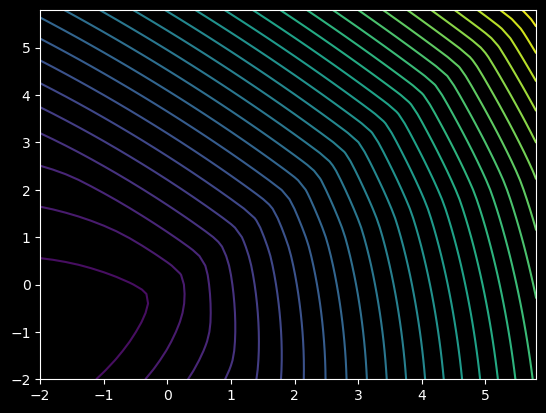

In [3]:
x = np.arange(-2.0, 6.0, 0.2)
y = np.arange(-2.0, 6.0, 0.2)
X, Y = np.meshgrid(x, y)
Z = jnp.array([jnp.array([xx, yy]) for xx, yy in zip(np.ravel(X), np.ravel(Y))])
Z = jax.vmap(phi)(Z).reshape(X.shape)
plt.contour(X, Y, Z.reshape(X.shape), levels=30)

In [4]:
# Recover velocity field from potential


def velocity_from_potential(
    phi: Callable[[jnp.ndarray], jnp.ndarray],
) -> Callable[[float, jnp.ndarray], jnp.ndarray]:

    @jax.jit
    @functools.partial(jax.vmap, in_axes=[None, 0])
    def vel(t, z):
        def phit(x: jnp.ndarray) -> jnp.ndarray:
            return 0.5 * (1 - t) * jnp.sum(x**2) + t * phi(x)

        x = jax.grad(legendre(phit))(z)
        return jax.grad(phi)(x) - x

    return vel

Our goal in this notebook is to illustrate these ground truth {term}`Monge map` and ground truth {term}`Benamou-Brenier` velocity field.

We do so by defining a source point cloud. Here this a simple concatenation of slightly off-centered noisy 2D toruses. For plotting purposes we also sample a smaller subset of these points that we will highlight in plots later on.

In [5]:
batch = 100
hl_batch = 10  # Smaller batch to highlight in plots.

# Generate point cloud near the unit circle.


def gen_torus_points(key, fraction=0.7, size=1):
    points = jax.random.normal(key, (size, 2))
    points /= jnp.linalg.norm(points, axis=-1, keepdims=True) + 1e-8
    torus_norms = (
        2 * (1 - fraction) * jax.random.uniform(jax.random.key(1), (size,))
        + fraction
    )
    points *= torus_norms[:, None]
    return points


# Define a small linear transformation
D = jnp.array(((0.4, -0.1), (-0.1, 1.2)))

points = jnp.concatenate(
    (
        gen_torus_points(jax.random.key(0), size=batch),
        gen_torus_points(jax.random.key(1), fraction=0.3, size=batch)
        + jnp.array((2, -0.5)) @ D,
    ),
    axis=0,
)

hl_points = jnp.concatenate(
    (
        gen_torus_points(jax.random.key(2), size=hl_batch) - 0.2,
        gen_torus_points(jax.random.key(3), fraction=0.3, size=hl_batch)
        + jnp.array((1.4, -0.3)) @ D,
    ),
    axis=0,
)

## Plots

The following plotting function is long, but allows to plot all cases considered in the rest of the notebook.

In [6]:
USE_MP4 = True  # False to have finer control on the animation


def plot_transport_animation(
    n_frames: int,
    static_points: jnp.ndarray,
    potential: Callable[[jnp.ndarray], jnp.ndarray],
    n_grid: int = 0,
    dynamic_points: Optional[jnp.ndarray] = None,
    points_grid: Optional[jnp.ndarray] = None,
    title: Optional[str] = None,
    plot_dynamic_transport: bool = False,
    plot_monge: bool = False,
    plot_ifm_interpolant: bool = False,
):
    global X_t, v_points
    batch = static_points.shape[0]
    plot_dynamic = plot_dynamic_transport or plot_monge
    sourcecolor = "lightcoral" if DARKMODE else "red"
    newsourcecolor = "salmon" if DARKMODE else "red"
    targetcolor = "deepskyblue" if DARKMODE else "blue"
    edgecolor = "white" if DARKMODE else "black"
    arrowscolor = "white" if DARKMODE else "black"
    ifmcolor = "palegreen" if DARKMODE else "green"
    small_alpha = 0.2

    # Marker styles for different types of points
    # Regular points
    xkw = {
        "s": 50,
        "label": r"$\mu_0$",
        "marker": "o",
        "color": sourcecolor,
        "edgecolor": edgecolor,
        "alpha": small_alpha if plot_dynamic else 0.9,
    }
    xtkw = {
        "s": 40,
        "label": r"$\mu_t$",
        "edgecolor": edgecolor,
        "color": sourcecolor,
    }

    # New Batch of Points
    xnkw = {
        "s": 60,
        "marker": "h",
        "edgecolor": edgecolor,
        "color": newsourcecolor,
        "alpha": 0.7 if plot_dynamic else 0.9,
    }
    xntkw = {
        "s": 60,
        "marker": "h",
        "edgecolor": edgecolor,
        "alpha": 1.0,
        "color": newsourcecolor,
    }

    # Target Points
    ykw = {
        "s": 50,
        "label": r"$\mu_1$",
        "marker": "s",
        "edgecolor": edgecolor,
        "color": targetcolor,
        "alpha": small_alpha if plot_dynamic else 0.9,
    }

    # IFM Points
    pkw = {
        "s": 50,
        "label": r"IFM $\mu_t$",
        "marker": "d",
        "edgecolor": edgecolor,
        "color": ifmcolor,
        "alpha": 0.9,
    }

    fig, ax = plt.subplots(figsize=(8, 6))
    fig.tight_layout(pad=2.0)
    times = jnp.linspace(0.0, 1.0, n_frames)
    delta_times = jnp.diff(times)

    static_end_points = jax.vmap(jax.grad(potential))(static_points)

    ax.scatter(static_points[:, 0], static_points[:, 1], **xkw)
    ax.scatter(static_end_points[:, 0], static_end_points[:, 1], **ykw)

    # By default, dynamic points are the same as static points
    dt = 1.0 if plot_monge or n_frames == 1 else delta_times[0]
    dyn_points = static_points if dynamic_points is None else dynamic_points

    if plot_dynamic:
        ax.scatter(dyn_points[:, 0], dyn_points[:, 1], **xnkw)

        v_points = jax.vmap(jax.grad(potential))(dyn_points) - dyn_points
        X_t = dyn_points

        quiver_points = ax.quiver(
            dyn_points[:, 0],
            dyn_points[:, 1],
            dt * v_points[:, 0],
            dt * v_points[:, 1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color=arrowscolor,
            alpha=0.8,
        )

        scatter_interm_points = ax.scatter(
            dyn_points[:, 0] + v_points[:, 0] * dt,
            dyn_points[:, 1] + v_points[:, 1] * dt,
            **(xtkw if dynamic_points is None else xntkw),
        )

    dyn_end_points = jax.vmap(jax.grad(potential))(dyn_points)

    if dynamic_points is not None:
        ax.scatter(dynamic_points[:, 0], dynamic_points[:, 1], **xnkw)

    all_points = jnp.concatenate(
        (
            dyn_points,
            dyn_end_points if dyn_end_points is not None else dyn_points,
            static_points,
            static_end_points,
        ),
        axis=0,
    )

    xlimits = jnp.min(all_points[:, 0]), jnp.max(all_points[:, 0])
    ylimits = jnp.min(all_points[:, 1]), jnp.max(all_points[:, 1])

    xscale = xlimits[1] - xlimits[0]
    yscale = ylimits[1] - ylimits[0]
    xlimits = (xlimits[0] - 0.05 * xscale, xlimits[1] + 0.05 * xscale)
    ylimits = (ylimits[0] - 0.05 * yscale, ylimits[1] + 0.05 * yscale)

    if n_grid > 0:
        x = jnp.linspace(*xlimits, n_grid)
        y = jnp.linspace(*ylimits, n_grid)
        X, Y = jnp.meshgrid(x, y)
        points_grid = jnp.stack([X, Y], axis=-1).reshape(-1, 2)
        plot_grid = True
    else:
        plot_grid = False

    if plot_grid:

        v_grid = velocity_from_potential(potential)(times[0], points_grid)

        quiver_grid = ax.quiver(
            points_grid[:, 0],
            points_grid[:, 1],
            dt * v_grid[:, 0],
            dt * v_grid[:, 1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color=arrowscolor,
            alpha=0.6 if plot_dynamic else 0.95,
        )

    if plot_ifm_interpolant:
        product_points = jnp.stack(
            (
                jnp.repeat(static_points, axis=0, repeats=batch),
                jnp.tile(static_end_points, reps=(batch, 1)),
            )
        )
        product_points_at_t = product_points[0, :, :]
        prod_scatter = ax.scatter(
            product_points_at_t[:, 0], product_points_at_t[:, 1], **pkw
        )

    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    ax.set_aspect("equal")
    ax.set_xlim(*xlimits)
    ax.set_ylim(*ylimits)

    def update_frame(frame):
        global X_t, v_points
        t = times[frame]
        if plot_grid and t < 1.0:
            dt = delta_times[frame - 1] if frame > 0 else delta_times[0]
            v_grid = velocity_from_potential(phi)(t, points_grid)
            quiver_grid.set_UVC(dt * v_grid[:, 0], dt * v_grid[:, 1])

        if plot_dynamic and not plot_monge:
            dt = delta_times[frame - 1] if frame > 0 else delta_times[0]
            if t >= 1.0:
                v_points = np.zeros_like(v_points)  # Stop moving at t=1.0

            X_t = (1 - t) * dyn_points + t * dyn_end_points

            if t < 1.0:
                quiver_points.set_offsets(X_t)
                quiver_points.set_UVC(dt * v_points[:, 0], dt * v_points[:, 1])
                scatter_interm_points.set_offsets(X_t + v_points * dt)

        if plot_grid or plot_dynamic and not plot_monge:
            ax.set_title(title + " at time " + f"{t:.2f}")

        if plot_ifm_interpolant:
            product_points_at_t = (1 - t) * product_points[
                0, :, :
            ] + t * product_points[1, :, :]
            prod_scatter.set_offsets(product_points_at_t)
            ax.set_title(title + " at time " + f"{t:.2f}")

    ani = animation.FuncAnimation(
        fig, update_frame, frames=n_frames, blit=False, interval=100
    )
    if n_frames == 1:
        plt.show()
    else:
        plt.close()
        if USE_MP4:
            display.display(display.HTML(ani.to_html5_video()))
        else:
            html = display.HTML(ani.to_jshtml())
            display.display(
                html,
            )
            plt.close()

## Data and Monge Solution

We first plot the source data and the {term}`push-forward` measure obtained by
applying $\nabla\phi$ to all these source points.

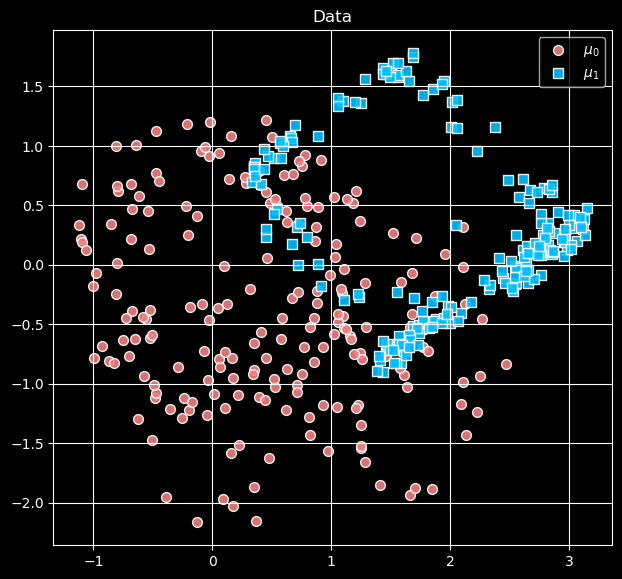

In [7]:
plot_transport_animation(
    n_frames=1,
    title="Data",
    static_points=points,
    potential=phi,
)

We show more explicitly the {term}`Monge map` linking each source point to its target point.

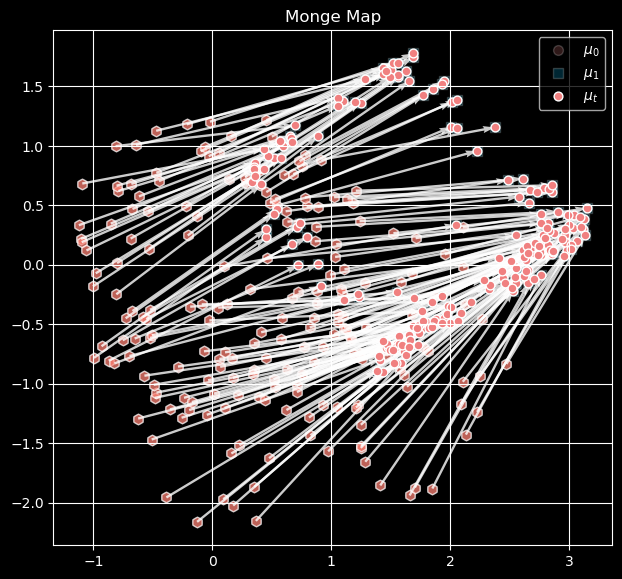

In [8]:
plot_transport_animation(
    n_frames=1,
    title="Monge Map",
    static_points=points,
    plot_monge=True,
    potential=phi,
)

### McCann Interpolation and Independent Flow Matching

This {term}`Monge map` can be presented in a dynamic view, by plotting all barycenters linking source points to target points, $x_t=(1-t)x + t \nabla\varphi(x)$, to form the so-called McCann interpolation {cite}`mccann:97`.

In [9]:
plot_transport_animation(
    n_frames=11,
    title="McCann Interpolation",
    static_points=points,
    plot_dynamic_transport=True,
    potential=phi,
)

As a short digression, the McCann interpolation (which requires the knowledge of the optimal transport map) can be contrasted with the independent coupling interpolation advocated in flow-matching, e.g. {cite}`lipman:22`, and which is extremely easy to compute by sampling independently a point from the source, then the target, and then link them.

In [10]:
plot_transport_animation(
    n_frames=11,
    title="Flow-Matching Interpolant",
    static_points=points,
    plot_ifm_interpolant=True,
    potential=phi,
)

### Benamou-Brenier Solution

We now illustrate the {term}`Benamou-Brenier` solution by displaying the time and space varying vector field $\Delta t \times v_t(\cdot)$,

In [11]:
plot_transport_animation(
    n_frames=11,
    title="Benamou-Brenier Velocity",
    n_grid=21,
    static_points=points,
    potential=phi,
)

And illustrate that integration more carefully on one subset of highlighted points.

In [12]:
plot_transport_animation(
    n_frames=11,
    title="Benamou-Brenier Integration",
    n_grid=21,
    static_points=points,
    dynamic_points=hl_points,
    plot_dynamic_transport=True,
    potential=phi,
)